Install Required Packages

In [1]:
# %%capture --no-stderr
# %pip install -U langchain_community tiktoken langchainhub chromadb langchain langgraph nlangchain_ollama langchain_huggingface

In [2]:
local_llm = "mistral"

Create Index

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain.docstore.in_memory import InMemoryDocstore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
import faiss
import numpy as np

embedding_model = HuggingFaceEmbeddings(model_name="multi-qa-mpnet-base-dot-v1")

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_spliter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)

doc_splits = text_spliter.split_documents(docs_list)
doc_embedding = [embedding_model.embed_query(doc.page_content) for doc in doc_splits]

dimension = len(doc_embedding[0])
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(np.array(doc_embedding))

docstore = InMemoryDocstore({str(i): doc for i, doc in enumerate(doc_splits)})
index_to_docstore_id = {i: str(i) for i in range(len(doc_splits))}


vectorstore = FAISS(
    embedding_function=embedding_model,
    docstore=docstore,
    index_to_docstore_id=index_to_docstore_id,
    index=faiss_index
)

retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 5})

query = "Tell me about LangChain"
retrieved_docs = retriever.get_relevant_documents(query)

for doc in retrieved_docs:
    print(f"Content: {doc.page_content}, Metadata: {doc.metadata}")


USER_AGENT environment variable not set, consider setting it to identify your requests.


Content: "content": "You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\n\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\n\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lowercase file name including the file extension,\nLANG is the markup code block language for the code's language, and CODE is the code:\n\nFILENAME\n```LANG\nCODE\n```\n\nYou will start with the \"entrypoint\" file, then go to the ones that are imported by that file, and so on.\nPlease

C:\Users\hasans\AppData\Local\Temp\ipykernel_15628\4280462970.py:45: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)


In [4]:
retriever.invoke("agent memory")

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

LLM

Retriever Grader

In [7]:
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

llm = ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"]
)

retriever_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.invoke(question)
doc_text = docs[1].page_content
print(retriever_grader.invoke(
    {
        "question" : question,
        "document" : doc_text
    }
))

{'score': 'yes'}


In [ ]:
# question = "huggingface"
# docs = retriever.invoke(question)
# doc_text = docs[1].page_content
# print(retriever_grader.invoke(
#     {
#         "question" : question,
#         "document" : doc_text
#     }
# ))
# print(docs[1])

Generate

In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = PromptTemplate(
   template= """
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
""",
input_variables=["context", "question"]
)
generate_llm = ChatOllama(model=local_llm, temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = generate_prompt | generate_llm | StrOutputParser()

generation = rag_chain.invoke(
    {
        "context": docs,
        "question" : question
    }
)
print(generation)

 The post discusses the concept of an autonomous agent system powered by a large language model (LLM). This system is designed to perform complex tasks efficiently and adaptively, using planning, memory, and tool use.

1. Planning: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. It also reflects on past actions, learns from mistakes, and refines its strategies for future steps to improve the quality of results.

2. Memory: The system has two types of memory: short-term (STM) and long-term (LTM). STM stores information that is currently needed for complex cognitive tasks like learning and reasoning, while LTM can store information for a remarkably long time, ranging from a few days to decades. LTM has two subtypes: explicit/declarative memory (memory of facts and events) and implicit/procedural memory (skills and routines performed automatically).

3. Tool use: The agent learns to call external APIs for extra information

Hallucination Grader

In [9]:
hallucination_model = ChatOllama(model=local_llm, format="json", temperature=0)

hallucination_prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"]
)

hallucination_grader = hallucination_prompt | hallucination_model | JsonOutputParser()
hallucination_grader.invoke(
    {
        "documents" : docs,
        "generation" : generation
    }
)

{'score': 'yes'}

Answer Grader

In [10]:

grader_model = ChatOllama(model=local_llm, format="json", temperature=0)

grader_prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
    )

answer_grader = grader_prompt | grader_model | JsonOutputParser()
answer_grader.invoke(
    {
        "question" : question,
        "generation" : generation
    }
)

{'score': 'yes'}

Question Re-Writer

In [11]:
re_writer_model = ChatOllama(model = local_llm, temperature=0)

re_write_prompt = PromptTemplate(
        template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_re_writer = re_write_prompt | re_writer_model | StrOutputParser()
question_re_writer.invoke(
    {
        "question" : question
    }
)

" What is the function of an agent's memory in a given context?"

Graph

Graph State

In [12]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation:str
    documents:List[str]

Nodes

In [13]:
##Retrieve
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    
    documents = retriever.invoke(question)
    return{"documents":documents, "question":question}

##Generate
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({
        "context" : documents,
        "question" : question
    })
    return {"documents" : documents,"question" : question,"generation" : generation}

def grade_doduments(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    documents = state['documents']

    filtered_docs = []
    for d in documents:
        score = retriever_grader.invoke(
            {
                "question" : question,
                "document" : documents
            }
        )
        grade = score["score"]
        if grade == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents" : filtered_docs, "question" : question}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    #re-write question
    better_question = question_re_writer.invoke({"question":question})
    return {"documents":documents, "question":better_question}

Edges

In [14]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        print("---DECISION: GENERATE---")
        return "generate"
    
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLICINATION---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {
            "documents" : documents,
            "generation" : generation
        }
    )
    grade = score['score']

    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        print("---GRADE GENERATION VS QUESTION---")
        score = answer_grader.invoke({
            "question":question,
            "generation":generation
        })
        grade = score["score"]

        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("___DECISION: GENERATION DOEST NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


Build Graph

In [15]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

#nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_doduments)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)

#edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query":"transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": END,
        "useful":END,
        "not useful": "transform_query"
    }
)

app = workflow.compile()

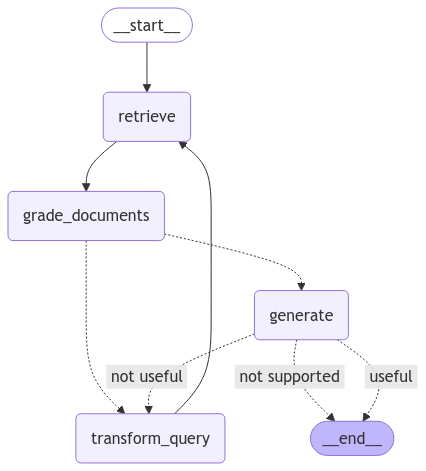

In [16]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

Run

In [18]:
from pprint import pprint

inputs = {
    "question" : "agentic ai and memory usage"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}:")
    pprint("\n---\n")
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve:"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents:"
'\n---\n'
---GENERATE---
---CHECK HALLICINATION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION VS QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate:"
'\n---\n'
(' In a Large Language Model (LLM) powered autonomous agent system, planning '
 'is one of the key components. The agent breaks down complex tasks into '
 'smaller, manageable subgoals, enabling efficient handling. This process is '
 'often achieved using techniques like Chain of Thought (CoT) or Tree of '
 'Thoughts (ToT).\n'
 '\n'
 '   CoT instructs the model to "think step by step" to utilize more test-time '
 'computation and decompose hard tasks into smaller

In [19]:
from pprint import pprint

inputs = {
    "question" : "summarize the indormation you have about agentic ai"
}

for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}:")
    pprint("\n---\n")
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve:"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents:"
'\n---\n'
---GENERATE---
---CHECK HALLICINATION---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION VS QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate:"
'\n---\n'
(' The document discusses the concept of building autonomous agents using '
 'large language models (LLMs) as their core controllers, with examples such '
 'as AutoGPT, GPT-Engineer, and BabyAGI. The agent system consists of several '
 'key components, including planning, memory, and tool use.\n'
 '\n'
 '   In the planning component, the agent breaks down complex tasks into '
 'smaller, manageable subgoals to handle them efficiently. This involves '
 'self-reflec